In [1]:
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def build_tuple(cdf, num_wolves):
    set = []
    while(len(set) < num_wolves):
        wolf_pos = 0
        rand = r.random()
        for i in cdf:
            if rand < i:
                break
            wolf_pos += 1
        if wolf_pos in set:
            continue
        set += [wolf_pos]
    return tuple(sorted(set))



def cdf_arrays(player_ct):
    """produces a parabola with f(0) = 0, f(1) = 4 and f(player_ct) = 0, as well as a list of x/player_ct from 1 to player_ct-1.
    the first array, when fed into the build_tuple function, produces equal odds of mafia being distributed into any position;
    when you add some amount of the second array to the first array, the odds of being lower in the list increase smoothly relative 
    to being higher in the list. scaled such that when you add the second list 10 times, the wolfiest slot is twice as likely to be
    a wolf as random, and the towniest slot is town 100% of the time.
    
    probably there was a more straightforward way to do this."""
    func = np.linalg.inv(np.array([[0, 0, 1], [1, 1, 1], [player_ct**2, player_ct, 1]]))@np.array([[0], [4], [0]])
    return np.array([x/player_ct for x in range(1, player_ct)]), 1/(40*player_ct)*np.array([func[0, 0]*x**2 + func[1, 0]*x for x in range(1, player_ct)])

cdf_arrays(13)


#np.linalg.inv(np.array([[0, 0, 1], [1, 1, 1], [9**2, 9, 1]]))@np.array([[0], [4], [0]])

(array([0.07692308, 0.15384615, 0.23076923, 0.30769231, 0.38461538,
        0.46153846, 0.53846154, 0.61538462, 0.69230769, 0.76923077,
        0.84615385, 0.92307692]),
 array([0.00769231, 0.01410256, 0.01923077, 0.02307692, 0.02564103,
        0.02692308, 0.02692308, 0.02564103, 0.02307692, 0.01923077,
        0.01410256, 0.00769231]))

<Axes: >

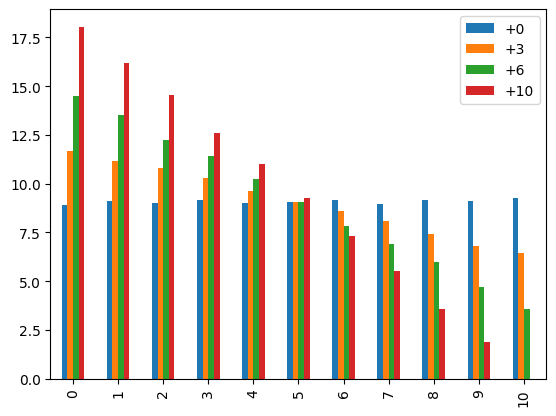

In [24]:
def test_set(cdf, app, mods, n_w):
    set = [build_tuple(cdf + mods*app, n_w) for i in range(100000)]
    out = [0] * (len(cdf)+1)
    for i in set:
        for n in i:
            out[n] +=1
    out = np.array(out)/(1000*n_w)
    return out


cdf1, app1 = cdf_arrays(9)
cdf2, app2 = cdf_arrays(11)

#nightless 9p
#pd.DataFrame({f"+{x}":test_set(cdf1, app1, x, 2) for x in [0, 3, 6, 10]}, index=[x for x in range(len(cdf1)+1)]).plot(kind="bar", sharex=True)
#mountainous 11p
#pd.DataFrame({f"+{x}":test_set(cdf2, app2, x, 3) for x in [0, 3, 6, 10]}, index=[x for x in range(len(cdf2)+1)]).plot(kind="bar", sharex=True)


In [34]:
def vic_9p_nightless(tup): #0, 1, 2, 3, 4, 5, 6, 7, 8
    mafia_victory = tup[2] >= 7 or tup[1] >=5 or tup[0]>= 3
    elo = tup[0] <=2 and tup[1] <= 4 and tup[2]>=6

    return not mafia_victory, elo # sup clodpoles

def vic_8p_nightless(tup): #0, 1, 2, 3, 4, 5, 6, 7
    mafia_victory = tup[2] >= 6 or tup[1] >=4 or tup[0]>= 2
    elo = tup[1] <= 3 and tup[2]>=5

    return not mafia_victory, elo

def vic_15p_nightless(tup): 
    mafia_victory = tup[4] >= 13 or tup[3] >= 11 or tup[2] >= 9 or tup[1] >= 7 or tup[0] >=5
    elo = tup[3] <=10 and tup[4] >= 12

    return not mafia_victory, elo


def vic_11p_mountainous(tup): #0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
    mafia_victory = tup[1] >= 5
    elo = tup[0] <=3 and tup[1]>=4
    return not mafia_victory, elo

def vic_15p_mountainous(tup): #0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
    mafia_victory = tup[1] >= 7
    elo = tup[0] <=5 and tup[1]>=6
    return not mafia_victory, elo

def vic_25p_mountainous(tup): 
    mafia_victory = tup[1] >= 12
    elo = tup[0] <=10 and tup[1]>=11
    return not mafia_victory, elo

#truly no excuse not to have a "n-player mountainous victory" function. not like it would be very hard.
#i just kept adding one new one at a time at various points

#also i made this and at some point forgot it's not meant to be equivalent to 12p like the nightless
#setups are. its just that the winrate improves so minutely that you could think they're within some margin


def winrates(cdf, num_wolves, function):
    set = [function(build_tuple(cdf, num_wolves)) for i in range(100000)]
    wins = 0
    elo_wins = 0
    elo_ct = 1
    for x in set:
        wins += 1 if x[0] else 0
        elo_wins += 1 if x[0] and x[1] else 0
        elo_ct += 1 if x[1] else 0
    
    return wins/100000, elo_wins/elo_ct if elo_ct > 0 else 0

#winrates(cdf2, 2, vic_11p_mountainous), cdf2

cdf8, app8 = cdf_arrays(8)
cdf15, app15 = cdf_arrays(15)
cdf25, app25 = cdf_arrays(25)


n8 = [winrates(cdf8 + x * app8, 3, vic_8p_nightless) for x in range(-10, 30)]
n9 = [winrates(cdf1 + x * app1, 3, vic_9p_nightless) for x in range(-10, 30)]
m11 = [winrates(cdf2 + x * app2, 2, vic_11p_mountainous) for x in range(-10, 30)]
#m15 = [winrates(cdf15 + x * app15, 2, vic_15p_mountainous) for x in range(-10, 30)]
m25 = [winrates(cdf25 + x * app25, 2, vic_25p_mountainous) for x in range(-10, 30)]
n15 = [winrates(cdf15 + x * app15, 5, vic_15p_nightless) for x in range(-10, 30)]

df = pd.DataFrame({
                   "nightless": [x[0] for x in n9], "nightless_elo": [x[1] for x in n9], 
                   "mountainous": [x[0] for x in m11], "mountainous_elo": [x[1] for x in m11],
                   "mountainous_25": [x[0] for x in m25], "mountainous_25_elo": [x[1] for x in m25],
                   "nightless_8": [x[0] for x in n8], "nightless_8_elo": [x[1] for x in n8], 
                   "nightless_15": [x[0] for x in n15], "nightless_15_elo": [x[1] for x in n15]
                   }, index = [x for x in range(-10, 30)])





<Axes: xlabel='skill measure', ylabel='probabilty of winning'>

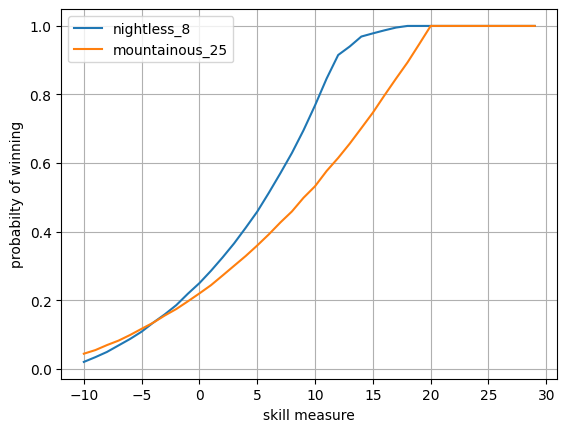

In [47]:
df["nightless_change"] = pd.Series([0] + [df["nightless"][x] - df["nightless"][x-1] for x in range(-9, 30)], [x for x in range(-10, 30)])
df["mountainous_change"] = pd.Series([0] + [df["mountainous"][x] - df["mountainous"][x-1] for x in range(-9, 30)], [x for x in range(-10, 30)])

#df[["nightless", "mountainous", "nightless_elo", "mountainous_elo"]].plot()
df[["nightless_8", "mountainous_25"]].plot(grid=True, xlabel="skill measure", ylabel="probabilty of winning")

<Axes: >

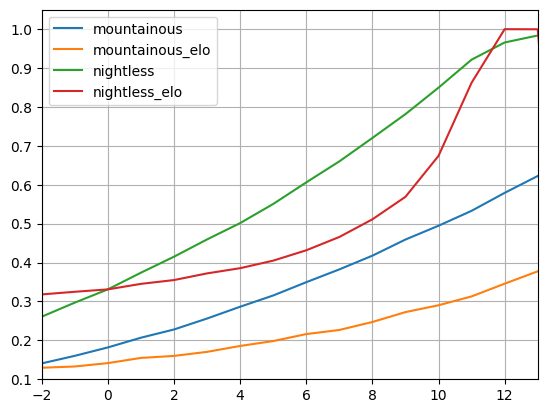

In [53]:
df[["mountainous", "mountainous_elo", "nightless", "nightless_elo"]].plot(xlim=(-2, 13), ylim=(0.1, 1.05), yticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], grid=True)

<Axes: >

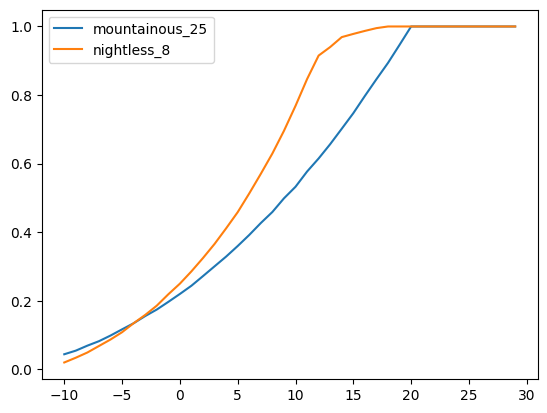

In [37]:
df[["mountainous_25", "nightless_8"]].plot()

In [46]:
(df["nightless"] - df["mountainous"])


-10    0.02896
-9     0.04094
-8     0.04977
-7     0.06120
-6     0.07341
-5     0.08659
-4     0.09495
-3     0.11145
-2     0.12005
-1     0.13679
 0     0.14921
 1     0.16712
 2     0.18704
 3     0.20334
 4     0.21495
 5     0.23521
 6     0.25659
 7     0.27764
 8     0.30259
 9     0.32233
 10    0.35491
 11    0.38854
 12    0.38655
 13    0.36111
 14    0.32001
 15    0.27528
 16    0.22911
 17    0.17499
 18    0.11912
 19    0.06085
 20    0.00000
 21    0.00000
 22    0.00000
 23    0.00000
 24    0.00000
 25    0.00000
 26    0.00000
 27    0.00000
 28    0.00000
 29    0.00000
dtype: float64

<Axes: >

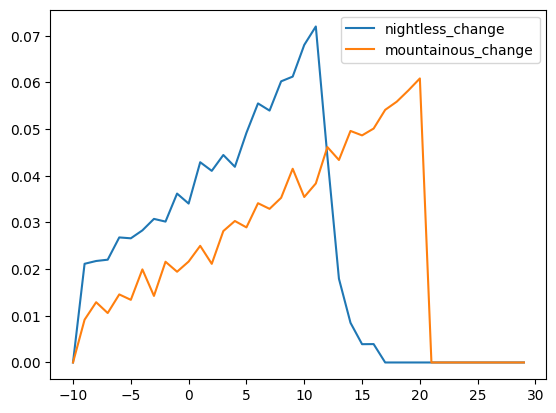

In [36]:
df[["nightless_change", "mountainous_change"]].plot()

<Axes: >

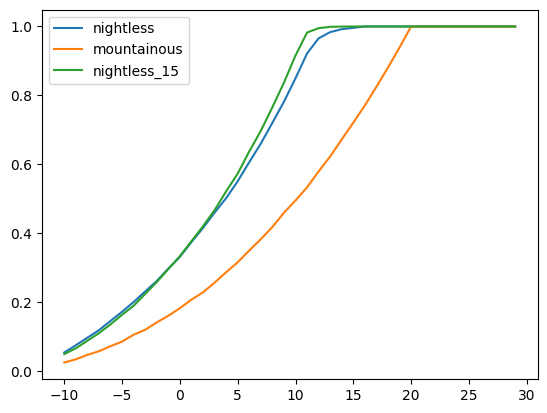

In [48]:

df[["nightless", "mountainous", "nightless_15"]].plot()

<Axes: >

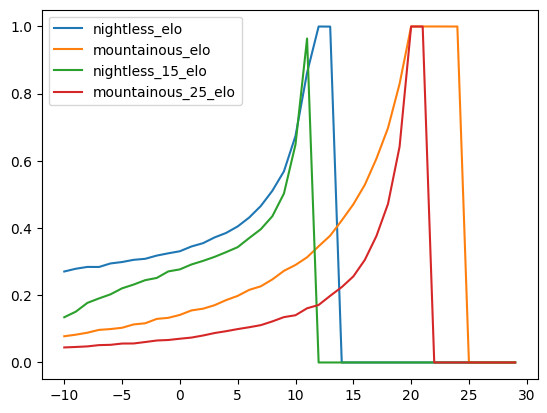

In [39]:
df[["nightless_elo", "mountainous_elo", "nightless_15_elo", "mountainous_25_elo"]].plot()

In [11]:
combs = []
for x in range(2, 9):
    for y in range(1, x):
        for z in range(0, y):
            combs += [(z, y, x)]

losers = []
for x in combs:
    if not vic_9p_nightless(x)[0]:
        losers += [x]
len(losers)

56

In [38]:
def vic_99p_mountainous(tup): 
    mafia_victory = tup[1] >= 49
    elo = tup[0] <=47 and tup[1]>=48
    return not mafia_victory, elo

winrates(cdf_arrays(99)[0], 2, vic_99p_mountainous)

(0.2442, 0.019864408119700354)